## Transfer Learning을 사용

In [1]:
# use Transfer Learning
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy


transform = transforms.Compose([
        transforms.Resize(224, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 40

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset=torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

dataloaders = {'train' : trainloader, 'val' : testloader }
dataset_sizes = { 'train' : len(trainset) , 'val' : len(testset) }

class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/inhamath/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  car   cat  deer  bird


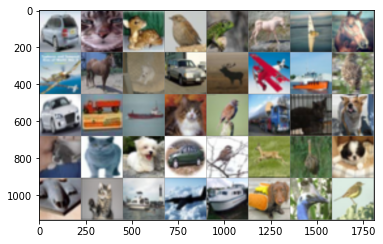

In [2]:
# 이미지 시각화 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()
#print(tf.size(images))

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))
plt.show()

In [3]:
# 모델 정의하기 

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10).cuda()

model_ft = model_ft.to(device)

In [4]:
# 손실함수 & optimizer 정의하기 
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # dataloader로부터 dataset과 그에 해당되는 label을 불러온다.
            for inputs, labels in dataloaders[phase]:  
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림
                # zero the parameter gradients
                optimizer.zero_grad()  #Gradient를 0으로 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).cuda()
                    _, preds = torch.max(outputs, 1) # 마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    loss = criterion(outputs, labels).cuda()

                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss.backward()
                        optimizer.step()
                    else:
                        preds=preds.cpu()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                preds = preds.cuda()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)


print('================Finished modeling')

Epoch 0/19
----------


/home/inhamath/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.4108 Acc: 0.8674
val Loss: 0.2007 Acc: 0.9313

Epoch 1/19
----------
train Loss: 0.1534 Acc: 0.9483
val Loss: 0.1668 Acc: 0.9427

Epoch 2/19
----------
train Loss: 0.0858 Acc: 0.9730
val Loss: 0.1601 Acc: 0.9454

Epoch 3/19
----------
train Loss: 0.0480 Acc: 0.9860
val Loss: 0.1621 Acc: 0.9470

Epoch 4/19
----------
train Loss: 0.0272 Acc: 0.9937
val Loss: 0.1744 Acc: 0.9465

Epoch 5/19
----------
train Loss: 0.0177 Acc: 0.9964
val Loss: 0.1651 Acc: 0.9492

Epoch 6/19
----------
train Loss: 0.0113 Acc: 0.9985
val Loss: 0.1614 Acc: 0.9507

Epoch 7/19
----------
train Loss: 0.0096 Acc: 0.9989
val Loss: 0.1621 Acc: 0.9517

Epoch 8/19
----------
train Loss: 0.0085 Acc: 0.9990
val Loss: 0.1591 Acc: 0.9519

Epoch 9/19
----------
train Loss: 0.0076 Acc: 0.9994
val Loss: 0.1579 Acc: 0.9523

Epoch 10/19
----------
train Loss: 0.0078 Acc: 0.9993
val Loss: 0.1597 Acc: 0.9523

Epoch 11/19
----------
train Loss: 0.0069 Acc: 0.9994
val Loss: 0.1598 Acc: 0.9525

Epoch 12/19
----------
t